In [187]:
import sys

import pandas as pd
import numpy as np
import time
from tqdm.autonotebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict, Counter

import scipy
from scipy.signal import welch
from scipy.fftpack import fft
from scipy import signal
from random import choice

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [7]:
data = pd.read_csv('../data/EpilepticSeizureRecognition.csv')
data.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [112]:
N = 178  # длина сигнала
t = 1  # длина нашего сигнала в секундах
T = t / N # период сигнала

# EDA

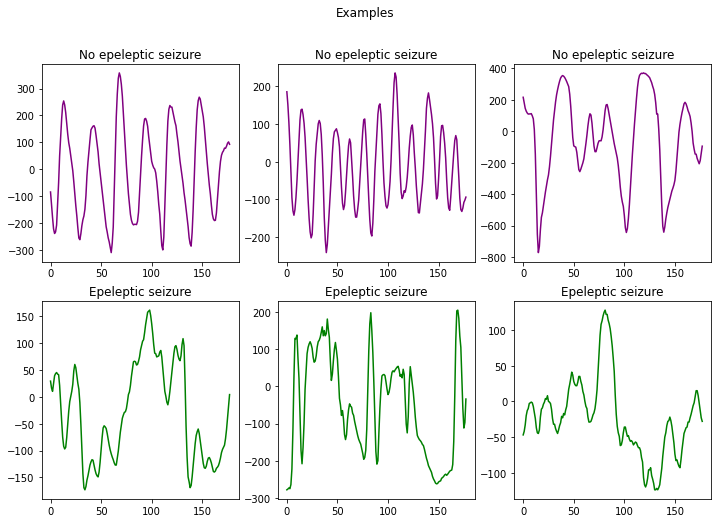

In [214]:
feature_cols = [col for col in data.columns if col.startswith('X')]

fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
fig.suptitle('Examples')

for row in range(2):
    for col in range(3):
        if row == 0:
            axarr[row][col].set_title('No epeleptic seizure')
            signal = data[feature_cols].loc[choice((data['y'] != 1).index)]
            color = 'purple'
        else:
            axarr[row][col].set_title('Epeleptic seizure')
            signal = data[feature_cols].loc[choice((data['y'] == 1).index)]
            color = 'green'
        axarr[row, col].plot(range(len(feature_cols)), signal.values, color=color)

plt.show()

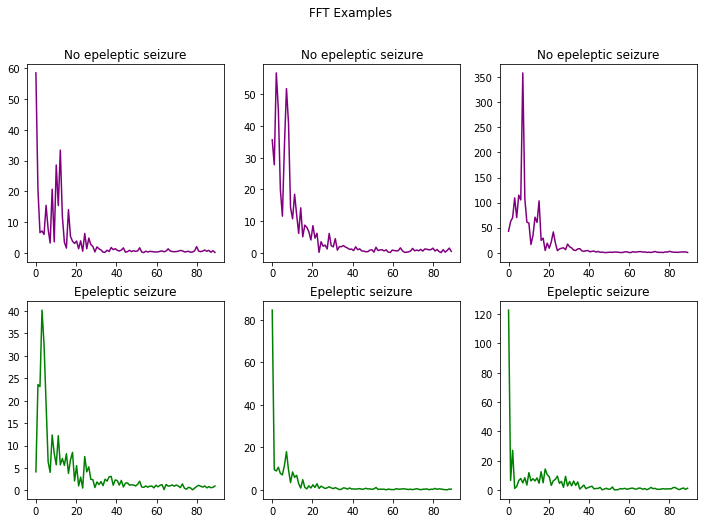

In [217]:
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
fig.suptitle('FFT Examples')

for row in range(2):
    for col in range(3):
        if row == 0:
            axarr[row][col].set_title('No epeleptic seizure')
            signal = data[feature_cols].loc[choice((data['y'] != 1).index)]
            f_values, fft_values = get_fft_values(signal, T, N, N)
            color = 'purple'
        else:
            axarr[row][col].set_title('Epeleptic seizure')
            signal = data[feature_cols].loc[choice((data['y'] == 1).index)]
            f_values, fft_values = get_fft_values(signal, T, N, N)
            color = 'green'
        axarr[row, col].plot(f_values, fft_values, color=color)

plt.show()

# ML Models

In [54]:
def choose_threshold(y_true, pred_proba, metric, thresholds=None):
    if thresholds is None:
        thresholds = np.arange(0, 1, 0.05)
    metric_values = [metric(y_true, pred_proba > thr) for thr in thresholds]
    best_thr = thresholds[np.argmax(metric_values)]
    return best_thr

In [15]:
data['y_bin'] = (data['y'] == 1).astype(int)  # 1 - означает эпелептический приступ

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data[[col for col in data.columns if col.startswith('X')]],
                                                    data['y_bin'], stratify=data['y_bin'], test_size=0.2)
y_train, y_test = y_train.values, y_test.values
len(y_train), len(y_test)

(9200, 2300)

In [123]:
roc_auc_dict = dict()
feature_count_dict = dict()

## Base features

In [169]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
threshold = choose_threshold(y_train, clf.predict_proba(X_train)[:, 1], f1_score)

In [170]:
y_pred = clf.predict_proba(X_test)[:, 1] > threshold
score = f1_score(y_test, y_pred)
roc_auc_dict['base_random_forest'] = score
print(score)

0.9378292939936775


In [124]:
feature_count_dict['base_random_forest'] = X_train.shape[1]

## FFT

In [117]:
import numpy as np

# Copied From http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
# Thank you Marcos Duarte

def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.
    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).
    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.
    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 
    See this IPython Notebook [1]_.
    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)
    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)
    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)
    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)
    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)
    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind

def get_values(y_values, T, N, f_s):
    y_values = y_values
    x_values = np.array([sample_rate * kk for kk in range(0,len(y_values))])
    return x_values, y_values

def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]
 
def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values

def get_first_n_peaks(x,y,no_peaks=5):
    x_, y_ = list(x), list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks], y_[:no_peaks]
    else:
        missing_no_peaks = no_peaks-len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks
    
def get_features(x_values, y_values, mph):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks])
    return peaks_x + peaks_y

def extract_features(dataset, T, N, f_s, denominator):
    percentile = 5
    list_of_features = []
    for signal_no in tqdm(range(0, len(dataset)), leave=False):
        features = []
        signal = dataset.iloc[signal_no]

        signal_min = np.nanpercentile(signal, percentile)
        signal_max = np.nanpercentile(signal, 100-percentile)
        #ijk = (100 - 2*percentile)/10
        mph = signal_min + (signal_max - signal_min)/denominator

        features += get_features(*get_psd_values(signal, T, N, f_s), mph)
        features += get_features(*get_fft_values(signal, T, N, f_s), mph)
        features += get_features(*get_autocorr_values(signal, T, N, f_s), mph)
        list_of_features.append(features)
    return np.array(list_of_features)

In [125]:
denominator = 10
X_train_fft = extract_features(X_train, T, N, N, denominator)
X_test_fft = extract_features(X_test, T, N, N, denominator)
feature_count_dict['fft_random_forest'] = X_train_fft.shape[1]

  0%|          | 0/9200 [00:00<?, ?it/s]

  0%|          | 0/2300 [00:00<?, ?it/s]

In [126]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_fft, y_train)
threshold = choose_threshold(y_train, clf.predict_proba(X_train_fft)[:, 1], f1_score)

In [127]:
y_pred = clf.predict_proba(X_test_fft)[:, 1] > threshold
score = f1_score(y_test, y_pred)
roc_auc_dict['fft_random_forest'] = score
print(score)

0.9506037321624589


## Wavelet

In [134]:
import pywt

In [148]:
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(
        np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features_w(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

def get_uci_har_features(dataset, waveletname):
    uci_har_features = []
    for signal_no in tqdm(range(0, len(dataset)), leave=False):
        features = []
        signal = dataset.iloc[signal_no]
        list_coeff = pywt.wavedec(signal, waveletname)
        for coeff in list_coeff:
            features += get_features_w(coeff)
        uci_har_features.append(features)
    X = np.array(uci_har_features)
    return X

In [145]:
waveletname = 'rbio3.1'
X_train_wavelet = get_uci_har_features(X_train, waveletname)
X_test_wavelet = get_uci_har_features(X_test, waveletname)
feature_count_dict['wavelet_random_forest'] = X_train.shape[1]

  0%|          | 0/9200 [00:00<?, ?it/s]

  0%|          | 0/2300 [00:00<?, ?it/s]

In [146]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_wavelet, y_train)
threshold = choose_threshold(y_train, clf.predict_proba(X_train_wavelet)[:, 1], f1_score)

In [147]:
y_pred = clf.predict_proba(X_test_wavelet)[:, 1] > threshold
score = f1_score(y_test, y_pred)
roc_auc_dict['wavelet_random_forest'] = score
print(score)

0.961038961038961


## TS Fresh

In [61]:
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

In [70]:
def get_long_df(data):  # Формат tsfresh библиотеки
    long_df = pd.DataFrame(
        {
            0: data.values.reshape(-1),
            1: np.arange(data.shape[0]).repeat(data.shape[1])
        }
    )
    return long_df

def extract_tsfeatures(data, settings):
    long_df = get_long_df(data)
    signal_features_df = extract_features(
        long_df, column_id=1, 
        impute_function=impute, 
        default_fc_parameters=settings,
        n_jobs=6,
        disable_progressbar=True,
        show_warnings=False
    )
    return signal_features_df

In [71]:
settings_efficient = settings.TimeBasedFCParameters()
settings_efficient.update(settings.MinimalFCParameters())
settings_efficient.update(settings.IndexBasedFCParameters())
settings_efficient

{'linear_trend_timewise': [{'attr': 'pvalue'},
  {'attr': 'rvalue'},
  {'attr': 'intercept'},
  {'attr': 'slope'},
  {'attr': 'stderr'}],
 'sum_values': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variance': None,
 'root_mean_square': None,
 'maximum': None,
 'minimum': None,
 'skewness': None,
 'kurtosis': None,
 'percentage_of_reoccurring_datapoints_to_all_datapoints': None}

In [72]:
X_train_tsfresh = extract_tsfeatures(X_train, settings_efficient)
X_test_tsfresh = extract_tsfeatures(X_test, settings_efficient)

In [172]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_tsfresh, y_train)
threshold = choose_threshold(y_train, clf.predict_proba(X_train_tsfresh)[:, 1], f1_score)

In [173]:
y_pred = clf.predict_proba(X_test_tsfresh)[:, 1] > threshold
score = f1_score(y_test, y_pred)
roc_auc_dict['tsfresh_random_forest'] = score
print(score)

0.9377049180327868


In [128]:
feature_count_dict['tsfresh_random_forest'] = X_train_tsfresh.shape[1]

## TSFEL

In [78]:
import tsfel

In [79]:
cfg_file = tsfel.get_features_by_domain('temporal')

In [96]:
X_train_tsfel = tsfel.time_series_features_extractor(cfg_file, np.expand_dims(X_train.values, -1), fs=N)
X_test_tsfel = tsfel.time_series_features_extractor(cfg_file, np.expand_dims(X_test.values, -1), fs=N)

*** Feature extraction started ***


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [176]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_tsfel, y_train)
threshold = choose_threshold(y_train, clf.predict_proba(X_train_tsfel)[:, 1], f1_score)

In [177]:
y_pred = clf.predict_proba(X_test_tsfel)[:, 1] > threshold
score = f1_score(y_test, y_pred)
roc_auc_dict['tsfel_random_forest'] = score
print(score)

0.9606986899563318


In [129]:
feature_count_dict['tsfel_random_forest'] = X_train_tsfel.shape[1]

## All

In [160]:
X_train_all = np.concatenate([X_train, X_train_fft, X_train_wavelet, X_train_tsfresh, X_train_tsfel], axis=1)
X_test_all = np.concatenate([X_test, X_test_fft, X_test_wavelet, X_test_tsfresh, X_test_tsfel], axis=1)
feature_count_dict['all_random_forest'] = X_train_all.shape[1]

In [161]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_all, y_train)
threshold = choose_threshold(y_train, clf.predict_proba(X_train_all)[:, 1], f1_score)

In [162]:
y_pred = clf.predict_proba(X_test_all)[:, 1] > threshold
score = f1_score(y_test, y_pred)
roc_auc_dict['all_random_forest'] = score
print(score)

0.9587852494577008


# Сравнение результатов

In [186]:
pd.DataFrame({'f1_score': roc_auc_dict, 'feature count':feature_count_dict}).sort_values('f1_score', ascending=False)

,f1_score,feature count
wavelet_random_forest,0.961039,178
tsfel_random_forest,0.960699,18
all_random_forest,0.958785,310
fft_random_forest,0.950604,30
base_random_forest,0.937829,178
tsfresh_random_forest,0.937705,12


 Лучшие результаты получились при использовании wavelet признаков, но при этом f1-мера у модели с tsfel признаками не сильно хуже, однако количество признаков почти в 10 раз меньше